# MLP for HZZ4l analysis using  Keras
Authors: Javier Duarte, Thong Nguyen     
Modified: Andre Sznajder

## **Mount Google Drive**

In [1]:
!fusermount -u drive
!pip install uproot

fusermount: failed to unmount /content/drive: No such file or directory
     |████████████████████████████████| 112kB 5.1MB/s 
     |████████████████████████████████| 92kB 27.2MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#Load data using PANDAS data frames#
Now we load two different `NumPy` arrays. One corresponding to the VBF H->ZZ->4l signal and the other one corresponds to the QCD ZZ->4l background .

In [0]:
import uproot
import numpy as np
import pandas as pd
import h5py

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

treename = 'HZZ4LeptonsAnalysisReduced'
filename = {}
upfile = {}
params = {}
df = {}

filename['VV'] = base_dir+'ntuple_qqH_ZZ4mu.root'
filename['bkg'] = base_dir+'ntuple_bkg_ZZ4mu.root'


# Variables from Roottree to be copyed to PANDA dataframe
VARS = ['f_lept1_pt','f_lept1_eta','f_lept1_phi', \
        'f_lept2_pt','f_lept2_eta','f_lept2_phi', \
        'f_lept3_pt','f_lept3_eta','f_lept3_phi', \
        'f_lept4_pt','f_lept4_eta','f_lept4_phi', \
        'f_jet1_pt','f_jet1_eta','f_jet1_phi', \
        'f_jet2_pt','f_jet2_eta','f_jet2_phi',\
        'f_mass4l','f_massjj','f_deltajj']
        

upfile['VV'] = uproot.open(filename['VV'])
upfile['bkg'] = uproot.open(filename['bkg'])

params['VV'] = upfile['VV'][treename].arrays(VARS)
params['bkg'] = upfile['bkg'][treename].arrays(VARS)

df['VV'] = pd.DataFrame(params['VV'],columns=VARS)
df['bkg'] = pd.DataFrame(params['bkg'],columns=VARS)

# Remove undefined variable entries VARS[i] <= -999
NDIM = len(VARS)
for i in range(NDIM):
    df['VV'] = df['VV'][(df['VV'][VARS[i]] > -999)]
    df['bkg']= df['bkg'][(df['bkg'][VARS[i]] > -999)]


# add isSignal variable
df['VV']['isSignal'] = np.ones(len(df['VV'])) 
df['bkg']['isSignal'] = np.zeros(len(df['bkg'])) 

## **Specify the number of NN input variables **

In [0]:

# Define the NN input variables 
#NVARS = len(VARS)
NVARS = len(VARS) - 3



## Define the model using KERAS functional API 
We'll start with a dense (fully-connected) NN layer.
Our model will have a single fully-connected hidden layer with the same number of neurons as input variables. 
The output layer contains a single neuron using a sigmoid activation in order to a number between 0 and 1 to make binary classification

We are using the `binary_crossentropy` loss function during training, a standard loss function for binary classification problems. 
We will optimize the model with the Adam algorithm for stochastic gradient descent and we will collect accuracy metrics while the model is trained.

In [6]:
# baseline keras model
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.layers import Input, Activation, Dense, Dropout
from keras.utils import np_utils

# Select the NN input variables. Using just lepton and and jets 4-mom ( low level veriables) ! 
input  = Input(shape=(NVARS,), name = 'input') 
#hidden = Dense(NVARS*3 , name = 'hidden', kernel_initializer='normal', activation='relu')(input)
#hidden = Dropout(rate=0.5)(hidden)
hidden1 = Dense(NVARS  , name = 'hidden1', kernel_initializer='normal', activation='relu')(input)
hidden1 = Dropout(rate=0.2)(hidden1)
hidden2 = Dense(NVARS  , name = 'hidden2', kernel_initializer='normal', activation='relu')(hidden1)
hidden2 = Dropout(rate=0.4)(hidden2)
hidden3 = Dense(NVARS  , name = 'hidden3', kernel_initializer='normal', activation='relu')(hidden2)
hidden3 = Dropout(rate=0.6)(hidden3)
output  = Dense(1      , name = 'output', kernel_initializer='normal', activation='sigmoid')(hidden3)

# create the model
model = Model(inputs=input, outputs=output)
# Define the optimizer ( minimization algorithm )
#optim = SGD(lr=0.01,decay=1e-6)
optim = Adam()
# compile the model
model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])
# print the model summary
model.summary()

Using TensorFlow backend.
W0721 16:09:08.401823 139723730757504 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 16:09:08.441498 139723730757504 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0721 16:09:08.462346 139723730757504 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 16:09:08.464097 139723730757504 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 18)                0         
_________________________________________________________________
hidden1 (Dense)              (None, 18)                342       
_________________________________________________________________
dropout_1 (Dropout)          (None, 18)                0         
_________________________________________________________________
hidden2 (Dense)              (None, 18)                342       
_________________________________________________________________
dropout_2 (Dropout)          (None, 18)                0         
_________________________________________________________________
hidden3 (Dense)              (None, 18)                342       
_________________________________________________________________
dropout_3 (Dropout)          (None, 18)                0         
__________

## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing). 


In [0]:
df_all = pd.concat([df['VV'],df['bkg']])
dataset = df_all.values
X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=6)

## Run NN Training 


In [8]:
# Number of training epochs
nepochs=500 
# Batch size
batch=100
# Train classifier
history = model.fit(X_train_val[:,0:NVARS], 
                    Y_train_val, 
                    epochs=nepochs, 
                    batch_size=batch, 
                    verbose=1, # switch to 1 for more verbosity 
                    validation_split=0.3)

Train on 8072 samples, validate on 3460 samples
Epoch 1/500
8072/8072 [==============================] - 1s 127us/step - loss: 0.4801 - acc: 0.8865 - val_loss: 0.2828 - val_acc: 0.9101
Epoch 2/500
8072/8072 [==============================] - 0s 19us/step - loss: 0.2771 - acc: 0.9141 - val_loss: 0.2187 - val_acc: 0.9104
Epoch 3/500
8072/8072 [==============================] - 0s 20us/step - loss: 0.2565 - acc: 0.9189 - val_loss: 0.2123 - val_acc: 0.9202
Epoch 4/500
8072/8072 [==============================] - 0s 20us/step - loss: 0.2465 - acc: 0.9238 - val_loss: 0.2121 - val_acc: 0.9286
Epoch 5/500
8072/8072 [==============================] - 0s 20us/step - loss: 0.2425 - acc: 0.9253 - val_loss: 0.2094 - val_acc: 0.9327
Epoch 6/500
8072/8072 [==============================] - 0s 21us/step - loss: 0.2441 - acc: 0.9262 - val_loss: 0.2092 - val_acc: 0.9324
Epoch 7/500
8072/8072 [==============================] - 0s 19us/step - loss: 0.2381 - acc: 0.9274 - val_loss: 0.2100 - val_acc: 0.9315

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

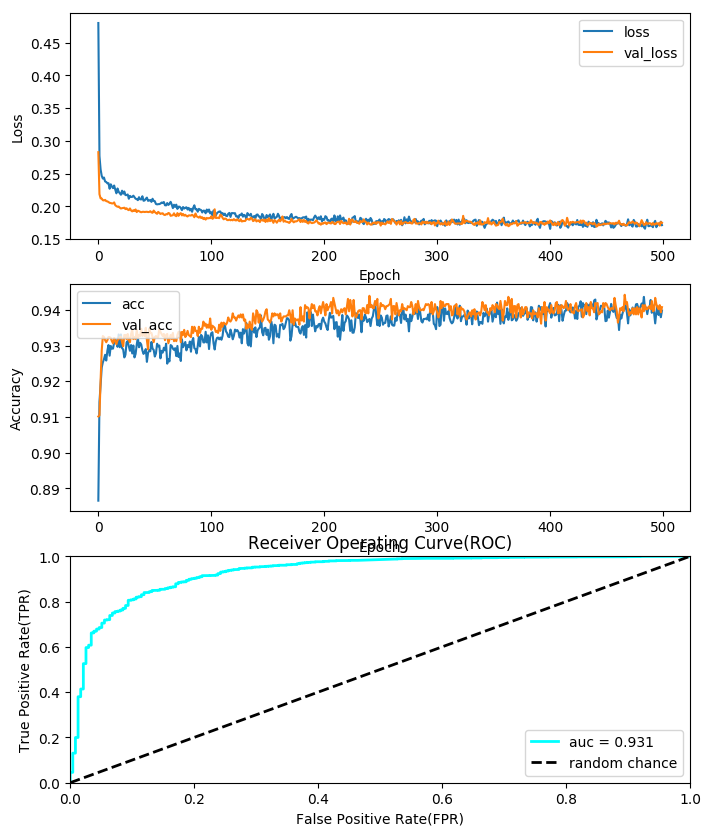

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
plt.figure(figsize=(8,10))

# plot loss vs epoch
ax = plt.subplot(3, 1, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend(loc="upper right")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# plot accuracy vs epoch
ax = plt.subplot(3, 1, 2)
ax.plot(history.history['acc'], label='acc')
ax.plot(history.history['val_acc'], label='val_acc')
ax.legend(loc="upper left")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

# Plot ROC
Y_predict = model.predict(X_test[:,0:NVARS])
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
ax = plt.subplot(3, 1, 3)
ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('False Positive Rate(FPR)')
ax.set_ylabel('True Positive Rate(TPR)')
ax.set_title('Receiver Operating Curve(ROC)')
ax.legend(loc="lower right")
plt.show()

# Plot  $m_{jj}$, $\eta_{j}$ and $m_{4l}$  for NN output > cut to show that the NN did learned the physics !


(50, 400)

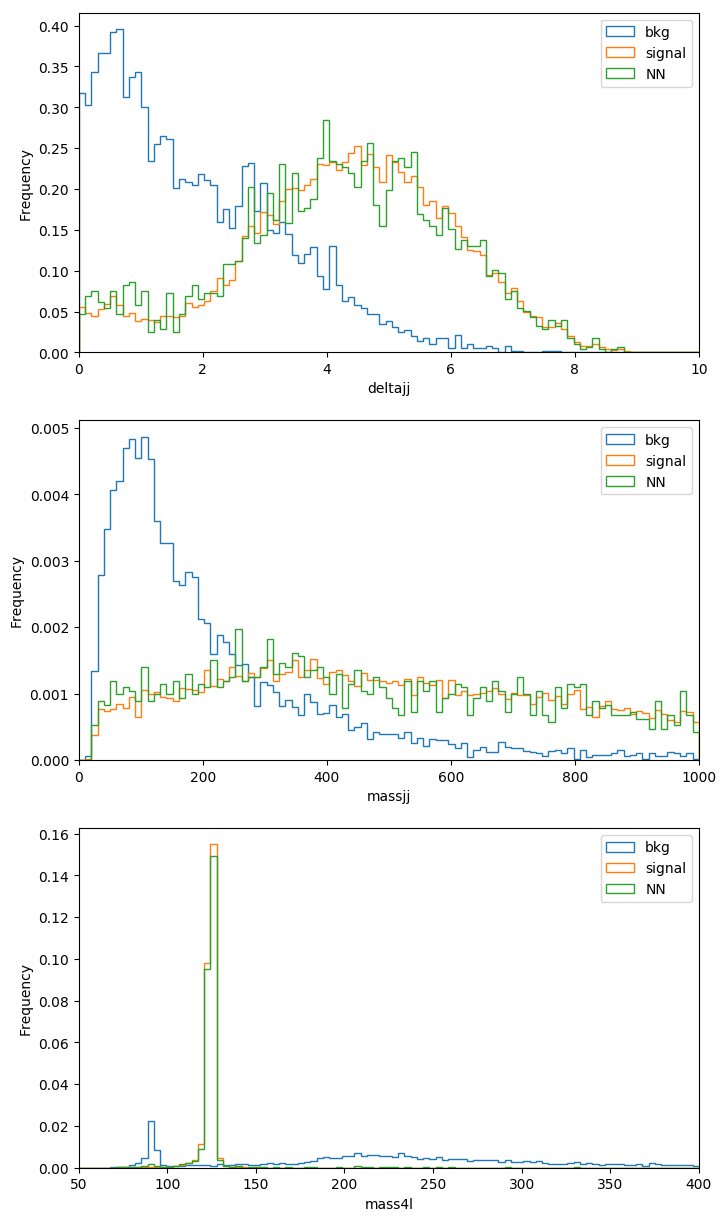

In [13]:

import matplotlib.pyplot as plt

# Define pandas dataframes the variables
VARS=['f_deltajj','f_massjj','f_mass4l']
params['VV'] = upfile['VV'][treename].arrays(VARS)
params['bkg'] = upfile['bkg'][treename].arrays(VARS)
df['VV'] = pd.DataFrame(params['VV'],columns=VARS)
df['bkg'] = pd.DataFrame(params['bkg'],columns=VARS)

# Remove events with undefined variable entries VARS[i] <= -999
N = len(VARS)
for i in range(N):
    df['VV'] = df['VV'][(df['VV'][VARS[i]] > -999)]
    df['bkg']= df['bkg'][(df['bkg'][VARS[i]] > -999)]


# Define the data frame for NN predictions and high level variables
data = pd.DataFrame({'f_mass4l':X_test[:,18],'f_massjj':X_test[:,19],'f_deltajj':X_test[:,20],'NNoutput':Y_predict[:,0]})

# Selects events with NNoutput > cut
cut = 0.5 
data = data[(data['NNoutput'] > cut)]

    
# Plot  delta_eta between jets for signal, background and NN selected events 
plt.style.use('default') # It's ugly otherwise
plt.figure(figsize=(8, 15),dpi=100)

plt.subplot(3, 1, 1)
plt.xlabel('deltajj')
bins = np.linspace(0, 10, 100)
df['bkg']['f_deltajj'].plot.hist(bins, label='bkg',histtype='step', density=1)
df['VV']['f_deltajj'].plot.hist(bins, label='signal',histtype='step', density=1)
data['f_deltajj'].plot.hist(bins, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(0,10)

# Plot  dijets mass for signal, background and NN selected events 
plt.subplot(3, 1, 2)
plt.xlabel('massjj')
bins = np.linspace(0, 1000, 100)
df['bkg']['f_massjj'].plot.hist(bins, label='bkg',histtype='step', density=1)
df['VV']['f_massjj'].plot.hist(bins, label='signal',histtype='step', density=1)
data['f_massjj'].plot.hist(bins, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(0,1000)

# Plot 4l invariant mass for signal, background and NN selected events 
plt.subplot(3, 1, 3)
plt.xlabel('mass4l')
bins = np.linspace(50, 400, 100)
df['bkg']['f_mass4l'].plot.hist(bins, label='bkg',histtype='step', density=1)
df['VV']['f_mass4l'].plot.hist(bins, label='signal',histtype='step', density=1)
data['f_mass4l'].plot.hist(bins, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(50,400)




**Question 1:** What happens if you increase/decrease the number of hidden layers ?



**Question 2:** What happens if you increase/decrease the number of nodes per hidden layer ?



**Question 3:** What happens if you remove dropout ?



**Question 4:** What happens if you change the batch size  ?



